In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import scipy.constants
import torch
from cdasws import CdasWs

In [2]:
time = ["2016-01-31T14:55:00Z", "2016-01-31T20:50:00Z"]

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [3]:
from pymfr.frame import estimate_ht_frame
from pymfr.axis import minimize_rdiff

electric_field = -torch.cross(velocity, magnetic_field)
frame = estimate_ht_frame(magnetic_field, electric_field)
# frame = velocity.mean(dim=0)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9
# gas_pressure = torch.zeros_like(gas_pressure)

trial_altitudes = np.linspace(0, 90, 180)
trial_azimuths = np.linspace(0, 360, 720)
trial_axes = [torch.tensor([np.sin(np.deg2rad(altitude)) * np.cos(np.deg2rad(azimuth)),
                            np.sin(np.deg2rad(altitude)) * np.sin(np.deg2rad(azimuth)),
                            np.cos(np.deg2rad(altitude))], dtype=torch.float32)
              for altitude in trial_altitudes
              for azimuth in trial_azimuths]
trial_axes.append(torch.tensor([0, 0, 1], dtype=torch.float32))
trial_axes = torch.row_stack(trial_axes)

from pymfr.axis import calculate_residue_map
residue_map = calculate_residue_map(magnetic_field, gas_pressure, frame, trial_axes)[:-1].reshape((180, 720)).numpy()
residue_map[residue_map == np.inf] = 1

best_axis, best_rdiff = minimize_rdiff(magnetic_field.cuda(),
                                       gas_pressure.cuda(),
                                       frame.cuda(),
                                       trial_axes.cuda())
best_axis = best_axis.cpu()
best_rdiff = best_rdiff.cpu()
best_axis, best_rdiff


(tensor([-0.4852, -0.2834,  0.8272]), tensor(0.0787))

In [4]:
trial_axes.shape

torch.Size([129601, 3])

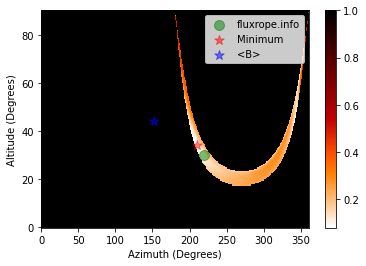

Altitude/azimuth: 34.189944874834566 / 210.29208374023438


/home/hafarooki/research/pymfr/venv/lib/python3.10/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


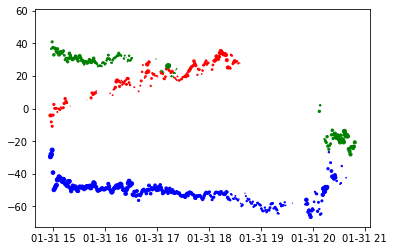

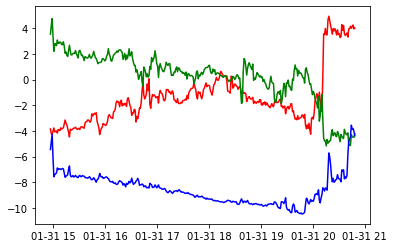

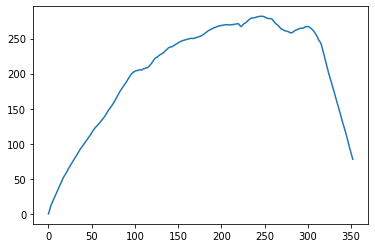

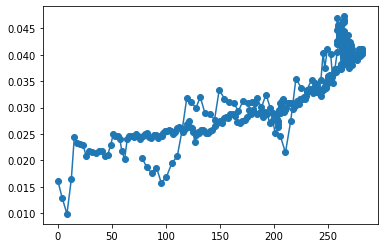

In [5]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x)) % 360
    return altitude, azimuth

altitude, azimuth = spherical(*best_axis.numpy())

plt.pcolormesh(trial_azimuths, trial_altitudes, residue_map, cmap="gist_heat_r")
plt.xlabel("Azimuth (Degrees)")
plt.ylabel("Altitude (Degrees)")
plt.colorbar()
plt.scatter([220], [30], color="green", marker="o", label="fluxrope.info", s=100, alpha=0.5)
plt.scatter([azimuth], [altitude], color="red", marker="*", label="Minimum", s=100, alpha=0.5)
plt.scatter(*spherical(*magnetic_field.numpy().mean(axis=0)), color="blue", marker="*", label="<B>", s=100, alpha=0.5)
plt.legend()
plt.show()

z_unit = np.array(best_axis)
frame = np.array(frame)

x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
x_unit = x_unit / np.linalg.norm(x_unit)
y_unit = np.cross(z_unit, x_unit)
rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

event_density = density.cpu().numpy()

alfven_velocity = magnetic_field / np.sqrt(scipy.constants.mu_0
                                        * scipy.constants.m_p
                                        * np.expand_dims(event_density, axis=1)) * 1e-15
remaining_flow = velocity - frame

d_flow = remaining_flow - remaining_flow.mean()
d_alfven = alfven_velocity - alfven_velocity.mean()
walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

# if walen_slope > 0.3:
#     continue

print("Altitude/azimuth:", altitude, "/", azimuth % 360)

colors = ["red", "green", "blue"]

for i_color, color in enumerate(colors):
    plt.scatter(times, alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
plt.show()

rotated = rotation_matrix @ magnetic_field.numpy().T
for i_color, color in enumerate(colors):
    plt.plot(times, rotated[i_color], color=color)
plt.show()

A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
plt.plot(A)
plt.show()

magnetic_transverse_pressure = (rotated[2] * 1e-9) ** 2 / (2 * scipy.constants.mu_0) * 1e9
P = gas_pressure + magnetic_transverse_pressure
plt.scatter(A, P)
plt.plot(A, P)
plt.show()

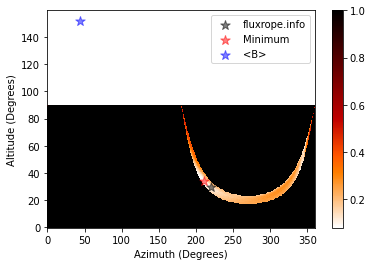

Altitude/azimuth: 34.189944874834566 / 210.29208374023438


/home/hafarooki/research/pymfr/venv/lib/python3.10/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


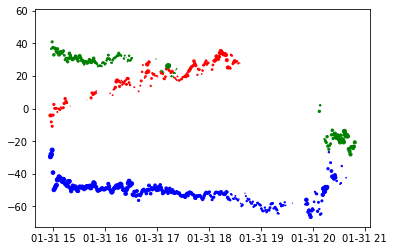

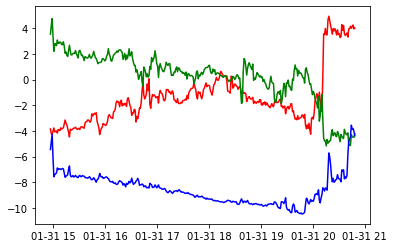

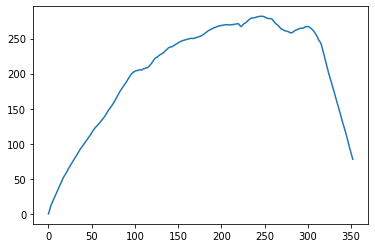

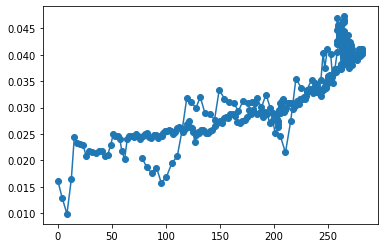

In [6]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x)) % 360
    return altitude, azimuth

altitude, azimuth = spherical(*best_axis.numpy())

plt.pcolormesh(trial_azimuths, trial_altitudes, residue_map, cmap="gist_heat_r")
plt.xlabel("Azimuth (Degrees)")
plt.ylabel("Altitude (Degrees)")
plt.colorbar()
plt.scatter([220], [30], color="black", marker="*", label="fluxrope.info", s=100, alpha=0.5)
plt.scatter([azimuth], [altitude], color="red", marker="*", label="Minimum", s=100, alpha=0.5)
plt.scatter(*spherical(*magnetic_field.numpy().mean(axis=0))[::-1], color="blue", marker="*", label="<B>", s=100, alpha=0.5)
plt.legend()
plt.show()

z_unit = np.array(best_axis)
frame = np.array(frame)

x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
x_unit = x_unit / np.linalg.norm(x_unit)
y_unit = np.cross(z_unit, x_unit)
rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

event_density = density.cpu().numpy()

alfven_velocity = magnetic_field / np.sqrt(scipy.constants.mu_0
                                        * scipy.constants.m_p
                                        * np.expand_dims(event_density, axis=1)) * 1e-15
remaining_flow = velocity - frame

d_flow = remaining_flow - remaining_flow.mean()
d_alfven = alfven_velocity - alfven_velocity.mean()
walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

# if walen_slope > 0.3:
#     continue

print("Altitude/azimuth:", altitude, "/", azimuth % 360)

colors = ["red", "green", "blue"]

for i_color, color in enumerate(colors):
    plt.scatter(times, alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
plt.show()

rotated = rotation_matrix @ magnetic_field.numpy().T
for i_color, color in enumerate(colors):
    plt.plot(times, rotated[i_color], color=color)
plt.show()

A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
plt.plot(A)
plt.show()

magnetic_transverse_pressure = (rotated[2] * 1e-9) ** 2 / (2 * scipy.constants.mu_0) * 1e9
P = gas_pressure + magnetic_transverse_pressure
plt.scatter(A, P)
plt.plot(A, P)
plt.show()